資料集

雲端(資料集下載): https://drive.google.com/file/d/1_rC3wId1gbdLRSexAx1IabjgJTJ8SyUF/view?usp=sharing

資料集檔案太大，傳不上去 Moodle 平台

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 

In [4]:
# 內存優化
d_types1 = {'user_id':'int32', 'item_id':'int32', 'cat_id':'int16', 'seller_id':'int16', 'brand_id':'float32', 'time_stamp':'int16', 'action_type':'int8'}
d_types2 = {'user_id':'int32', 'age_range':'float32', 'gender':'float32'}
d_types3 = {'user_id':'int32', 'merchant_id':'int16', 'label':'float32'}

In [7]:
df_train = pd.read_csv('./dataset/train_format1.csv', dtype = d_types3)
df_test = pd.read_csv('./dataset/test_format1.csv', dtype = d_types3)
user_info = pd.read_csv('./dataset/user_info_format1.csv', dtype = d_types2)
user_log = pd.read_csv('./dataset/user_log_format1.csv', dtype = d_types1)

In [8]:
# 調整數據
user_info = user_info[:200000]
user_log = user_log[:10000000]
data_train = df_train[:100000]
data_test = df_test[:100613]

In [9]:
display(user_log.head())
display(user_info.head())
display(df_train.head())
display(df_test.head())

,user_id,item_id,cat_id,seller_id,brand_id,time_stamp,action_type
0,328862,323294,833,2882,2661.0,829,0
1,328862,844400,1271,2882,2661.0,829,0
2,328862,575153,1271,2882,2661.0,829,0
3,328862,996875,1271,2882,2661.0,829,0
4,328862,1086186,1271,1253,1049.0,829,0


,user_id,age_range,gender
0,376517,6.0,1.0
1,234512,5.0,0.0
2,344532,5.0,0.0
3,186135,5.0,0.0
4,30230,5.0,0.0


,user_id,merchant_id,label
0,34176,3906,0.0
1,34176,121,0.0
2,34176,4356,1.0
3,34176,2217,0.0
4,230784,4818,0.0


,user_id,merchant_id,prob
0,163968,4605,NaN
1,360576,1581,NaN
2,98688,1964,NaN
3,98688,3645,NaN
4,295296,3361,NaN


## 資料前處理

##### 檢查資料類型

In [10]:
display(user_log.info())
display(user_info.info())
display(df_train.info())
display(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000000 entries, 0 to 9999999
Data columns (total 7 columns):
 #   Column       Dtype  
---  ------       -----  
 0   user_id      int32  
 1   item_id      int32  
 2   cat_id       int16  
 3   seller_id    int16  
 4   brand_id     float32
 5   time_stamp   int16  
 6   action_type  int8   
dtypes: float32(1), int16(3), int32(2), int8(1)
memory usage: 181.2 MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   user_id    200000 non-null  int32  
 1   age_range  199234 non-null  float32
 2   gender     197640 non-null  float32
dtypes: float32(2), int32(1)
memory usage: 2.3 MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260864 entries, 0 to 260863
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   user_id      260864 non-null  int32  
 1   merchant_id  260864 non-null  int16  
 2   label        260864 non-null  float32
dtypes: float32(1), int16(1), int32(1)
memory usage: 2.5 MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261477 entries, 0 to 261476
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   user_id      261477 non-null  int32  
 1   merchant_id  261477 non-null  int16  
 2   prob         0 non-null       float64
dtypes: float64(1), int16(1), int32(1)
memory usage: 3.5 MB


None

##### 缺失值處理

In [11]:
# NaN 當未知
# 使用 0 替換 NaN(age_range)
# 使用 2 替換 NaN(gender)

user_info['age_range'].replace(np.nan, 0, inplace = True)
user_info['gender'].replace(np.nan, 2, inplace = True)

user_info.head(132365)

C:\Users\Jack\AppData\Local\Temp\ipykernel_4704\3991436134.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  user_info['age_range'].replace(np.nan, 0, inplace = True)
C:\Users\Jack\AppData\Local\Temp\ipykernel_4704\3991436134.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

,user_id,age_range,gender
0,376517,6.0,1.0
1,234512,5.0,0.0
2,344532,5.0,0.0
3,186135,5.0,0.0
4,30230,5.0,0.0
...,...,...,...
132360,355774,0.0,1.0
132361,255504,2.0,0.0
132362,188928,0.0,2.0
132363,165645,4.0,0.0


##### 視覺化

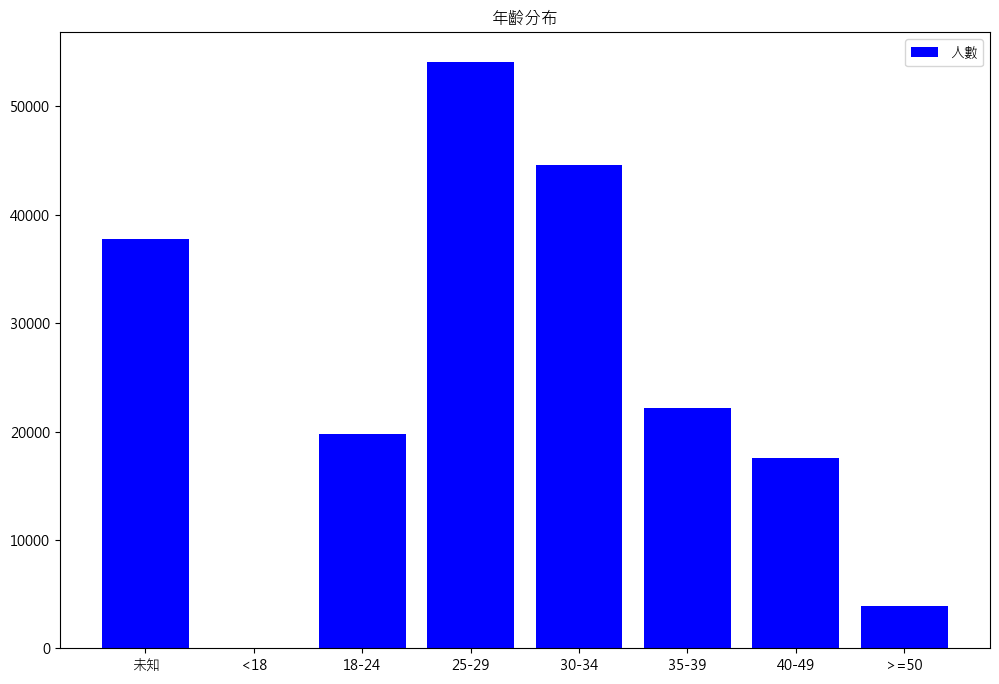

In [13]:
# 0:未知, 1:<18, 2:18-24, 3:25-29, 4:30-34, 5:35-39, 6:40-49, 7、8:>=50 
fig = plt.figure(figsize = (12, 8))

x = np.array(['未知', "<18","18-24","25-29","30-34","35-39","40-49",">=50"])
y = np.array([user_info[user_info['age_range'] == 0]['age_range'].count(),
              user_info[user_info['age_range'] == 1]['age_range'].count(),
              user_info[user_info['age_range'] == 2]['age_range'].count(),
              user_info[user_info['age_range'] == 3]['age_range'].count(),
              user_info[user_info['age_range'] == 4]['age_range'].count(),
              user_info[user_info['age_range'] == 5]['age_range'].count(),
              user_info[user_info['age_range'] == 6]['age_range'].count(),
              user_info[user_info['age_range'] == 7]['age_range'].count() + user_info[user_info['age_range'] == 8]['age_range'].count()])

plt.bar(x, y, color = 'blue')
plt.legend(['人數'])
plt.title('年齡分布')

# 儲存圖片
fig.savefig('./visualization/plot1.png',dpi=fig.dpi)

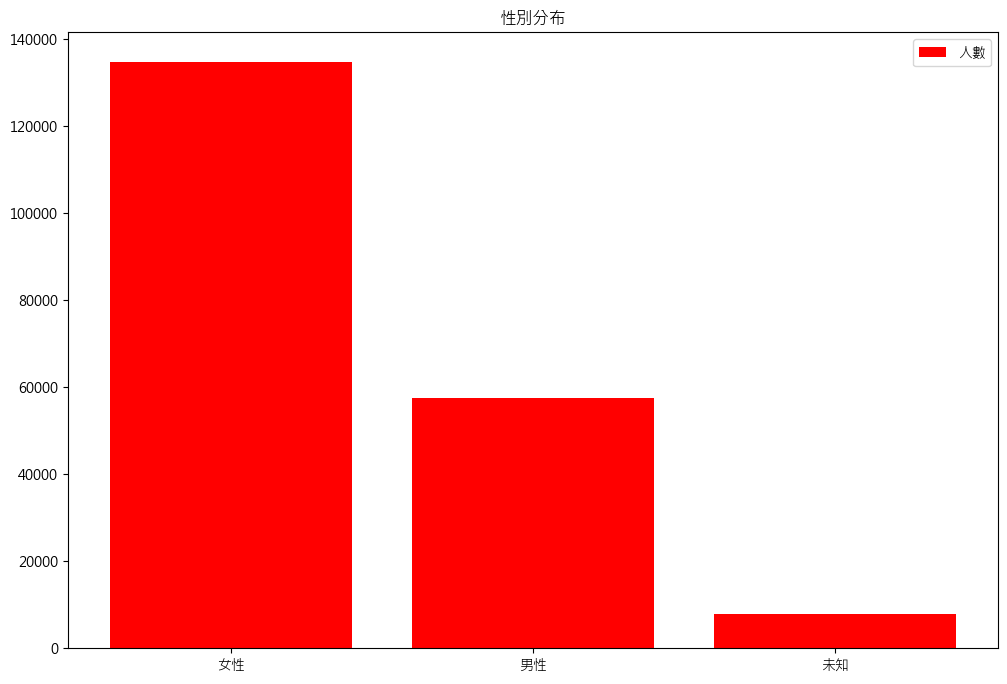

In [14]:
# 0:女性 , 1:男性 , 2、'':未知
fig = plt.figure(figsize = (12, 8))

x = np.array(['女性', '男性', '未知'])
y = np.array([user_info[user_info['gender'] == 0]['gender'].count(),
              user_info[user_info['gender'] == 1]['gender'].count(),
              user_info[user_info['gender'] == 2]['gender'].count()])

plt.bar(x, y, color = 'red')
plt.legend(['人數'])
plt.title('性別分布')

# 儲存圖片
fig.savefig('./visualization/plot2.png',dpi=fig.dpi)

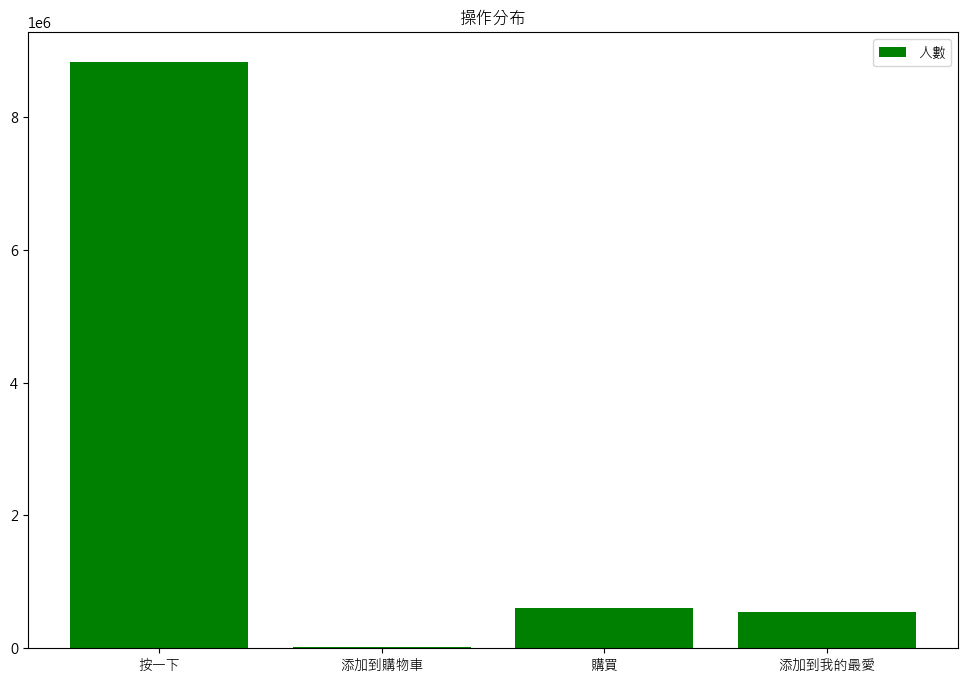

In [15]:
# 0:按一下 , 1:添加到購物車 , 2:購買, 3:添加到我的最愛
fig = plt.figure(figsize = (12, 8))

x = np.array(['按一下', '添加到購物車', '購買', '添加到我的最愛'])
y = np.array([user_log[user_log['action_type'] == 0]['action_type'].count(),
              user_log[user_log['action_type'] == 1]['action_type'].count(),
              user_log[user_log['action_type'] == 2]['action_type'].count(),
              user_log[user_log['action_type'] == 3]['action_type'].count()])

plt.bar(x, y, color = 'green')
plt.legend(['人數'])
plt.title('操作分布')

# 儲存圖片
fig.savefig('./visualization/plot3.png',dpi=fig.dpi)

## 特徵建立

建立特徵的參考網站: https://www.heywhale.com/mw/project/6044a21f6b48c2001529f1b5/content


In [16]:
# 合併 train data 和 test data
df_train["data"] = "train"
df_test["data"] = "test"
data = pd.concat([df_train, df_test])
data = data.drop(["prob"], axis = 1)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 522341 entries, 0 to 261476
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   user_id      522341 non-null  int32  
 1   merchant_id  522341 non-null  int16  
 2   label        260864 non-null  float32
 3   data         522341 non-null  object 
dtypes: float32(1), int16(1), int32(1), object(1)
memory usage: 13.0+ MB


In [17]:
# 統計性別和年齡

# 合並
data = pd.merge(data, user_info)
data.head()

,user_id,merchant_id,label,data,age_range,gender
0,231552,3828,1.0,train,5.0,0.0
1,231552,2124,0.0,train,5.0,0.0
2,232320,1168,0.0,train,4.0,1.0
3,232320,4270,0.0,train,4.0,1.0
4,298368,2981,0.0,train,4.0,0.0


##### 用戶-賣家特徵(按照 user_id, merchant_id 分組)

In [18]:
# 統計交互過的商品

uniq_item_id = user_log.groupby(["user_id", "seller_id", "item_id"]).count().reset_index()[["user_id", "seller_id", "item_id"]]

uniq_item_id_count = uniq_item_id.groupby(["user_id", "seller_id"]).count().reset_index()

uniq_item_id_count.rename(columns={"seller_id":"merchant_id", "item_id":"uniq_item_id"}, inplace = True)

# 合併
data = pd.merge(data, uniq_item_id_count)
data.head()

,user_id,merchant_id,label,data,age_range,gender,uniq_item_id
0,231552,3828,1.0,train,5.0,0.0,48
1,231552,2124,0.0,train,5.0,0.0,4
2,298368,2981,0.0,train,4.0,0.0,2
3,36480,4730,0.0,train,6.0,1.0,1
4,105600,1487,0.0,train,6.0,1.0,8


In [19]:
# 統計交互過的品類

cat_id_temp = user_log.groupby(["user_id", "seller_id", "cat_id"]).count().reset_index()[["user_id", "seller_id", "cat_id"]]

cat_id_temp_count = cat_id_temp.groupby(["user_id", "seller_id"]).count().reset_index()

cat_id_temp_count.rename(columns={"seller_id":"merchant_id", "cat_id":"total_cat_id"}, inplace = True)

# 合併
data = pd.merge(data, cat_id_temp_count)
data.head()

,user_id,merchant_id,label,data,age_range,gender,uniq_item_id,total_cat_id
0,231552,3828,1.0,train,5.0,0.0,48,15
1,231552,2124,0.0,train,5.0,0.0,4,1
2,298368,2981,0.0,train,4.0,0.0,2,1
3,36480,4730,0.0,train,6.0,1.0,1,1
4,105600,1487,0.0,train,6.0,1.0,8,1


In [20]:
# 統計交互天數

time_temp = user_log.groupby(["user_id", "seller_id", "time_stamp"]).count().reset_index()[["user_id", "seller_id", "time_stamp"]]

time_temp_count = time_temp.groupby(["user_id", "seller_id"]).count().reset_index()

time_temp_count.rename(columns={"seller_id":"merchant_id", "time_stamp":"total_time_temp"}, inplace = True)

# 合併
data = pd.merge(data, time_temp_count)
data.head()

,user_id,merchant_id,label,data,age_range,gender,uniq_item_id,total_cat_id,total_time_temp
0,231552,3828,1.0,train,5.0,0.0,48,15,3
1,231552,2124,0.0,train,5.0,0.0,4,1,1
2,298368,2981,0.0,train,4.0,0.0,2,1,3
3,36480,4730,0.0,train,6.0,1.0,1,1,1
4,105600,1487,0.0,train,6.0,1.0,8,1,3


In [21]:
# 統計點擊、添加購物車、購買、添加到我的最愛的操作次數

click_temp = user_log.groupby(["user_id", "seller_id", "action_type"])["item_id"].count().reset_index()

click_temp.rename(columns={"seller_id":"merchant_id", "item_id":"times"}, inplace = True)

click_temp["clicks"] = click_temp["action_type"] == 0

click_temp["clicks"] = click_temp["clicks"] * click_temp["times"]

click_temp["shopping_cart"] = click_temp["action_type"] == 1
click_temp["shopping_cart"] = click_temp["shopping_cart"] * click_temp["times"]

click_temp["purchases"] = click_temp["action_type"] == 2
click_temp["purchases"] = click_temp["purchases"] * click_temp["times"]

click_temp["favourites"] = click_temp["action_type"] == 3
click_temp["favourites"] = click_temp["favourites"] * click_temp["times"]

features = click_temp.groupby(["user_id", "merchant_id"]).sum().reset_index()

features = features.drop(["action_type", "times"], axis = 1)

# 合併
data = pd.merge(data, features)
data.head()

,user_id,merchant_id,label,data,age_range,gender,uniq_item_id,total_cat_id,total_time_temp,clicks,shopping_cart,purchases,favourites
0,231552,3828,1.0,train,5.0,0.0,48,15,3,78,0,5,0
1,231552,2124,0.0,train,5.0,0.0,4,1,1,6,0,1,0
2,298368,2981,0.0,train,4.0,0.0,2,1,3,4,0,1,0
3,36480,4730,0.0,train,6.0,1.0,1,1,1,2,0,1,0
4,105600,1487,0.0,train,6.0,1.0,8,1,3,20,0,1,0


In [22]:
# 購買點擊率
data["purchases_ctr"] = data["purchases"] / data["clicks"]
data.head()

,user_id,merchant_id,label,data,age_range,gender,uniq_item_id,total_cat_id,total_time_temp,clicks,shopping_cart,purchases,favourites,purchases_ctr
0,231552,3828,1.0,train,5.0,0.0,48,15,3,78,0,5,0,0.064103
1,231552,2124,0.0,train,5.0,0.0,4,1,1,6,0,1,0,0.166667
2,298368,2981,0.0,train,4.0,0.0,2,1,3,4,0,1,0,0.250000
3,36480,4730,0.0,train,6.0,1.0,1,1,1,2,0,1,0,0.500000
4,105600,1487,0.0,train,6.0,1.0,8,1,3,20,0,1,0,0.050000


In [23]:
# 儲存提取好的特徵
data.to_csv("./dataset/features.csv", index = False)

## 預測建模

In [24]:
new_data = pd.read_csv('./dataset/features.csv')

### 預處理

In [25]:
# 壓縮資料
fcols = new_data.select_dtypes('float').columns
icols = new_data.select_dtypes('integer').columns
new_data[fcols] = new_data[fcols].apply(pd.to_numeric, downcast='float')
new_data[icols] = new_data[icols].apply(pd.to_numeric, downcast='integer')

new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47511 entries, 0 to 47510
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   user_id          47511 non-null  int32  
 1   merchant_id      47511 non-null  int16  
 2   label            23687 non-null  float32
 3   data             47511 non-null  object 
 4   age_range        47511 non-null  float32
 5   gender           47511 non-null  float32
 6   uniq_item_id     47511 non-null  int16  
 7   total_cat_id     47511 non-null  int8   
 8   total_time_temp  47511 non-null  int8   
 9   clicks           47511 non-null  int16  
 10  shopping_cart    47511 non-null  int8   
 11  purchases        47511 non-null  int8   
 12  favourites       47511 non-null  int8   
 13  purchases_ctr    47511 non-null  float32
dtypes: float32(4), int16(3), int32(1), int8(5), object(1)
memory usage: 1.8+ MB


In [66]:
# 分成訓練集和測試集
train = new_data[new_data["data"] == "train"]
test = new_data[new_data["data"] == "test"].drop(["data", "label"], axis = 1)

In [73]:
# 提取 'user_id' 和 'merchant_id'
user_merchant_ids = test[['user_id', 'merchant_id']]

# 預測的測試集
pre_test = test.drop(['user_id', 'merchant_id'], axis = 1)

# 無限值替換成0
pre_test.replace([np.inf, -np.inf], 0, inplace = True)

       user_id  merchant_id
23687   360576         1581
23688   245376          390
23689   245376         1891
23690   245376         4034
23691   245376         2397
...        ...          ...
47506   215423         4356
47507   215423         1840
47508   347519          598
47509   151679         1272
47510   153215         3211

[23824 rows x 2 columns]
       age_range  gender  uniq_item_id  total_cat_id  total_time_temp  clicks  \
23687        2.0     2.0             9             4                1       5   
23688        0.0     0.0             1             1                2       2   
23689        0.0     0.0             1             1                1       0   
23690        0.0     0.0             1             1                2       1   
23691        0.0     0.0             1             1                3       1   
...          ...     ...           ...           ...              ...     ...   
47506        5.0     0.0             1             1                1  

In [28]:
X, y = train.drop(["user_id", "merchant_id", "label", 'data'], axis = 1), train["label"]

# 無限值替換成0
X.replace([np.inf, -np.inf], 0, inplace = True)

In [30]:
# 分成訓練集和驗證集
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2)

In [31]:
# 正樣本比例
print("訓練集正樣本比例: ", y_train.mean())
print("驗證集正樣本比例: ", y_valid.mean())

訓練集正樣本比例:  0.06464721
驗證集正樣本比例:  0.06352892


### 模型

In [32]:
from sklearn.metrics import roc_auc_score

##### 隨機森林(RandomForest)

In [33]:
from sklearn.ensemble import RandomForestClassifier

In [34]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [35]:
print('accuracy: ', rf.score(X_valid, y_valid))
print('roc_auccuracy: ', roc_auc_score(y_valid, rf.predict_proba(X_valid)[:, 1]))

accuracy:  0.9309835373575348
roc_auccuracy:  0.5641502257144505


In [36]:
# 最佳參數建立模型(參考 找出最佳模型參數.ipynb)

best_rf = RandomForestClassifier(max_depth = 5, min_samples_leaf = 50, min_samples_split = 2, n_estimators = 50)
best_rf.fit(X_train, y_train)

print('accuracy: ', best_rf.score(X_valid, y_valid))
print('roc_auccuracy: ', roc_auc_score(y_valid, best_rf.predict_proba(X_valid)[:, 1]))

accuracy:  0.9364710848459266
roc_auccuracy:  0.6084492604847339


<Axes: >

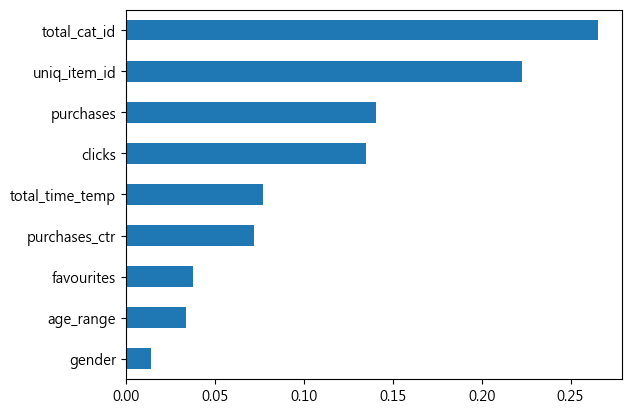

In [37]:
# 前十名特徵
features = pd.Series(best_rf.feature_importances_, index = X_train.columns).sort_values()
features[-9:].plot.barh()

In [38]:
# 預測
rf_predict_proba = best_rf.predict_proba(pre_test)
print(rf_predict_proba[:, 1])

[0.15584638 0.03795245 0.04185631 ... 0.05471041 0.0976593  0.04590294]


##### 邏輯迴歸(LogisticRegression)

In [39]:
from sklearn.linear_model import LogisticRegression

In [40]:
lg =  LogisticRegression()
lg.fit(X_train, y_train)

LogisticRegression()

In [41]:
print('accuracy: ', lg.score(X_valid, y_valid))
print('roc_auccuracy: ', roc_auc_score(y_valid, lg.predict_proba(X_valid)[:, 1]))

accuracy:  0.9352047277332207
roc_auccuracy:  0.6028376600573402


In [42]:
# 最佳參數建立模型(參考 找出最佳模型參數.ipynb)

best_lg =  LogisticRegression(C = 0.1, penalty = 'l1', solver = 'liblinear')
best_lg.fit(X_train, y_train)

print('accuracy: ', best_lg.score(X_valid, y_valid))
print('roc_auccuracy: ', roc_auc_score(y_valid, best_lg.predict_proba(X_valid)[:, 1]))

accuracy:  0.935415787252005
roc_auccuracy:  0.6039140061263746


In [43]:
# 預測
lg_predict_proba = best_lg.predict_proba(pre_test)
print(lg_predict_proba[:, 1])

[0.10190773 0.04970738 0.04701269 ... 0.053006   0.06084506 0.05458952]


##### XGBoost

In [45]:
from xgboost import XGBClassifier

In [46]:
xgc = XGBClassifier()
xgc.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [47]:
print('accuracy: ', xgc.score(X_valid, y_valid))
print('roc_auccuracy: ', roc_auc_score(y_valid, xgc.predict_proba(X_valid)[:, 1]))

accuracy:  0.9341494301392993
roc_auccuracy:  0.5454146908696651


In [48]:
# 最佳參數建立模型(參考 找出最佳模型參數.ipynb)

best_xgc = XGBClassifier(eta = 0.1, eval_metric = 'auc', gamma = 1, max_depth = 1, min_child_weight = 10, objective = 'binary:logistic', subsample = 0.5)
best_xgc.fit(X_train, y_train)

print('accuracy: ', best_xgc.score(X_valid, y_valid))
print('roc_auccuracy: ', roc_auc_score(y_valid, best_xgc.predict_proba(X_valid)[:, 1]))

accuracy:  0.9364710848459266
roc_auccuracy:  0.6143379030307659


<Axes: >

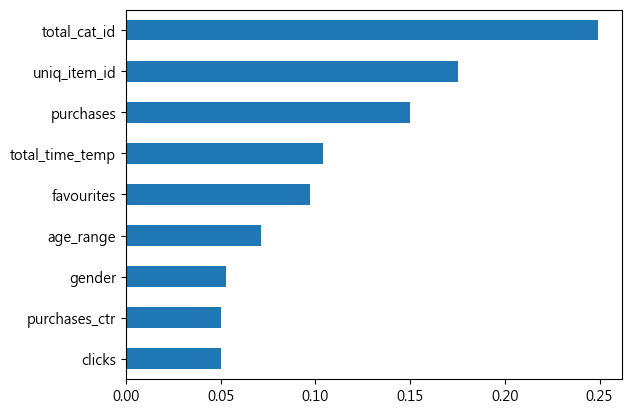

In [49]:
# 前十名特徵
features = pd.Series(best_xgc.feature_importances_, index = X_train.columns).sort_values()
features[-9:].plot.barh()

In [50]:
# 預測
xgc_predict_proba = best_xgc.predict_proba(pre_test)
print(xgc_predict_proba[:, 1])

[0.13788825 0.04150731 0.04136065 ... 0.04920672 0.11078418 0.04533434]


##### LightGBM

In [53]:
from lightgbm import LGBMClassifier

In [54]:
lgbm = LGBMClassifier()
lgbm.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 1225, number of negative: 17724
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001037 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 480
[LightGBM] [Info] Number of data points in the train set: 18949, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.064647 -> initscore=-2.671979
[LightGBM] [Info] Start training from score -2.671979


LGBMClassifier()

In [55]:
print('accuracy: ', lgbm.score(X_valid, y_valid))
print('roc_auccuracy: ', roc_auc_score(y_valid, lgbm.predict_proba(X_valid)[:, 1]))

accuracy:  0.9352047277332207
roc_auccuracy:  0.5907979337150524


In [56]:
# 最佳參數建立模型(參考 找出最佳模型參數.ipynb)

best_lgbm =  LGBMClassifier(boosting_type = 'goss', learning_rate = 0.05, max_depth = 50, min_split_gain = 0.05, num_leaves = 10, subsample = 0.5)
best_lgbm.fit(X_train, y_train)

print('accuracy: ', best_lgbm.score(X_valid, y_valid))
print('roc_auccuracy: ', roc_auc_score(y_valid, best_lgbm.predict_proba(X_valid)[:, 1]))

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 1225, number of negative: 17724
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001351 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 480
[LightGBM] [Info] Number of data points in the train set: 18949, number of used features: 10
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.064647 -> initscore=-2.671979
[LightGBM] [Info] Start training from score

<Axes: >

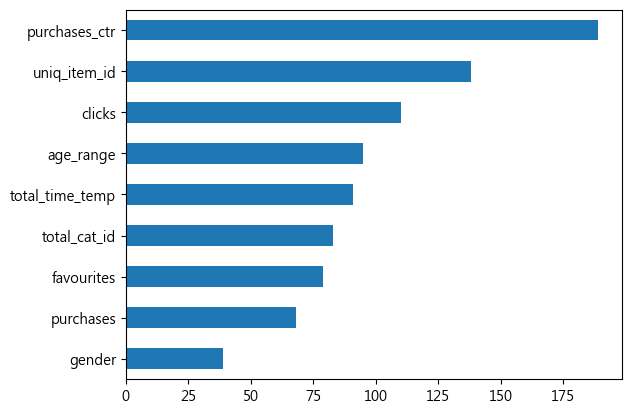

In [57]:
# 前十名特徵
features = pd.Series(best_lgbm.feature_importances_, index = X_train.columns).sort_values()
features[-9:].plot.barh()

In [58]:
# 預測
predict_proba = best_lgbm.predict_proba(pre_test)
print(predict_proba[:, 1])

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[0.16965784 0.03700176 0.03702008 ... 0.04330171 0.06760679 0.04519527]


## 選擇最佳模型

In [59]:
# 沒調過任何參數
auc_lg = roc_auc_score(y_valid, lg.predict_proba(X_valid)[:,1])
auc_rf =  roc_auc_score(y_valid, rf.predict_proba(X_valid)[:,1])
auc_xgc = roc_auc_score(y_valid, xgc.predict_proba(X_valid)[:,1])
auc_lgbm = roc_auc_score(y_valid, lgbm.predict_proba(X_valid)[:,1])

In [60]:
# 比較模型的準確率
scores = pd.DataFrame({ "model":["LogisticRegression","RandomForest","XGBoost", "LightGBM"],
                        "auc":[auc_lg, auc_rf, auc_xgc, auc_lgbm]})

scores.sort_values(by="auc", ascending = False)

,model,auc
0,LogisticRegression,0.602838
3,LightGBM,0.590798
1,RandomForest,0.564150
2,XGBoost,0.545415


In [61]:
# 調過最佳參數
best_auc_lg = roc_auc_score(y_valid, best_lg.predict_proba(X_valid)[:,1])
best_auc_rf =  roc_auc_score(y_valid, best_rf.predict_proba(X_valid)[:,1])
best_auc_xgc = roc_auc_score(y_valid, best_xgc.predict_proba(X_valid)[:,1])
best_auc_lgbm = roc_auc_score(y_valid, best_lgbm.predict_proba(X_valid)[:,1])

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.


In [62]:
# 比較模型的準確率
scores = pd.DataFrame({ "model":["LogisticRegression","RandomForest","XGBoost", "LightGBM"],
                        "auc":[best_auc_lg, best_auc_rf, best_auc_xgc, best_auc_lgbm]})

scores.sort_values(by="auc", ascending = False)

,model,auc
2,XGBoost,0.614338
3,LightGBM,0.612830
1,RandomForest,0.608449
0,LogisticRegression,0.603914


In [74]:
# 儲存最佳模型預測結果
list1 = []
for i in xgc_predict_proba[:, 1]:
    list1.append(i)

user_ids = user_merchant_ids['user_id'].tolist()  
merchant_ids = user_merchant_ids['merchant_id'].tolist() 

xgc_prob = pd.DataFrame({'user_id': user_ids, 'merchant_id': merchant_ids, 'prob':list1})
xgc_prob.to_csv('prediction.csv', index = False)

## 參考資料

2.用戶的復購預測

https://www.heywhale.com/mw/project/6044a21f6b48c2001529f1b5/content
